# Convolutional Neural Networks in Numpy

In A4, you will be using the implementation of convolutional neural networks using `numpy`.  It is defined in class `NeuralNetworkClassifier_CNN` provided in the tar file in A4.  Here we will discuss its implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks_A4 as nn

In [ ]:
# This code cell is not meant to be executed

######################################################################
## class NeuralNetworkClassifier_CNN(NeuralNetworkClassifier)
######################################################################

class NeuralNetworkClassifier_CNN(NeuralNetworkClassifier):

    def __init__(self, n_inputs, conv_layers, fc_layers, classes):
        '''
        n_inputs: image size is n_inputs x n_inputs x n_channels
        conv_layers: list of lists of ints, each being n_units, kernel_size, stride
        fc_layers: list of n_units per fully-connected layers
        classes: list of unique class labels
        '''

        self.n_inputs = n_inputs
        self.classes = classes
        self.n_outputs = len(classes)
        self.layers = [{'n_units': nu, 'kernel': k, 'stride': s} for (nu, k, s) in conv_layers] + \
            [{'n_units': nu} for nu in fc_layers] + [{'n_units': self.n_outputs, 'final': True}]

        # Build list of shapes for weight matrices in each layera
        shapes = []
        in_rc, in_rc, n_channels = n_inputs
        
        prev_layer = None
        for layer in self.layers:
            if 'kernel' in layer:
                n_in = 1 + layer['kernel'] ** 2 * n_channels
                W_shape = (n_in, layer['n_units'])
                out_rc = (in_rc - layer['kernel']) // layer['stride'] + 1
                if out_rc < 1:
                    raise Exception(f'Layer {layer=} cannot be created for the input size of {in_rc=}')
                layer.update({'in_channels': n_channels,
                              'in_rc': in_rc,
                              'out_rc': out_rc})
                shapes.append(W_shape)
                n_channels = layer['n_units']
                in_rc = layer['out_rc']
                prev_layer = layer
            else:
                if not prev_layer:
                    n_in = 1 + in_rc ** 2 * n_channels
                elif 'kernel' in prev_layer:
                    n_in = 1 + in_rc ** 2 * prev_layer['n_units']
                nu = layer['n_units']
                shapes.append((n_in, nu))
                n_in = 1 + nu
                prev_layer = layer
                
        self.all_weights, self.Ws = self._make_weights_and_views(shapes)
        self.all_gradients, self.Grads = self._make_weights_and_views(shapes)

        # Store references to W and G in layer dictionaries
        for layer, W, G in zip(self.layers, self.Ws, self.Grads):
            layer['W'] = W
            layer['G'] = G

        self.total_epochs = 0
        self.error_trace = []
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

    def __repr__(self):
        conv_layers = [(lay['n_units'], lay['kernel'], lay['stride']) for lay in self.layers if 'kernel' in lay]
        fc_layers = [lay['n_units'] for lay in self.layers if 'kernel' not in lay]
        details = ''
        for i, layer in enumerate(self.layers):
            if 'kernel' in layer:
                details += (f"\n Layer {i}: n_units={layer['n_units']} "
                            f"kernel={layer['kernel']} "
                            f"stride={layer['stride']} "
                            f"in_channels={layer['in_channels']} "
                            f"in_rc={layer['in_rc']} "
                            f"out_rc={layer['out_rc']}")
            else:
                if i != len(self.layers) - 1:
                    details += f"\n Layer {i}: n_units={layer['n_units']}"
                else:
                    details += []
        return f'{type(self).__name__}({self.n_inputs}, ' + \
            f'{conv_layers}, {fc_layers}, {self.n_classes})' + details
                

    def _forward(self, X):
        '''X assumed to be standardized
        '''
        debug = False
        
        N = X.shape[0]
        self.Ys = [X]
        n_layers = len(self.layers)
        for layer in self.layers:
            if debug: print(f'     ======== Input {self.Ys[-1].shape=}')
            W = layer['W']
            if 'kernel' in layer:
                Y = self._convolve(self.Ys[-1], layer)
                Y = np.tanh(Y + W[np.newaxis, np.newaxis, np.newaxis, 0, :])
            else:
                Y = self.Ys[-1]
                if Y.ndim > 2:
                    Y = Y.reshape(N, -1)
                Y = Y @ W[1:, :] + W[0:1, :]
                if 'final' not in layer:
                    Y = np.tanh(Y)
            self.Ys.append(Y)
            if debug: print(f'     ======== Output {self.Ys[-1].shape=}')

        return self.Ys

    # Gradient of function to be minimized for use by optimizer method
    def _gradient_f(self, X, T):
        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]

        Y = self._softmax(self.Ys[-1])

        Delta = -(T - Y) / (n_samples * n_outputs)
        self._backpropagate(Delta)

        return self.all_gradients

    def _backpropagate(self, Delta):
        # Step backwards through the convolutional layers to back-propagate the error (D)
        # Assumes self.Ys from convolutional layers represented as patches, as computed by _forward

        debug = False
        
        for layeri in range(len(self.layers) - 1, -1, -1):
            if debug: print(f'{layeri=} {Delta.shape=}')
            if layeri < len(self.layers) - 1:
                Delta *= 1 - self.Ys[layeri + 1] ** 2
            layer = self.layers[layeri]
            W = layer['W']
            if 'kernel' in layer:  # Convolutional layer
                Yin_patches = self._make_patches(self.Ys[layeri], layer['kernel'], layer['stride'])
                N, D, D, K, K, Uprev = Yin_patches.shape
                N, D, D, U = Delta.shape
                G = (Yin_patches.reshape(N * D * D, K * K * Uprev).T @ Delta.reshape(N * D * D, U))
                layer['G'][1:, :] = G
                layer['G'][0:1, :] = np.sum(Delta, axis=tuple(range(Delta.ndim - 1)))
                if layeri > 0:
                     # Delta = self._convolve_backprop(Delta, W[1:, :], layer['kernel'], layer['stride'])
                    # prev_layer = self.layers[layeri - 1]
                    Delta = self._convolve_backprop(Delta, W[1:, :], layer['kernel'], layer['stride'])
                if debug: print(f'Backpropagating {Delta.shape=}')
            else:
                # Fully connected
                N = Delta.shape[0]
                layer['G'][1:, :] = self.Ys[layeri].reshape(N, -1).T @ Delta
                layer['G'][0:1, :] = np.sum(Delta, axis=0)
                Delta = Delta @ W[1:, :].T
                Delta = Delta.reshape(self.Ys[layeri].shape)
                
        return self.all_gradients

    def _make_patches(self, X, patch_size, stride=1):
        '''
        X: n_samples x n_rows x n_cols x n_channels (r_rows == n_cols)
        patch_size: number of rows (= number of columns) in each patch
        stride: number of pixels to shfit to next patch (n rows = n columns)
        '''
        X = np.ascontiguousarray(X)  # make sure X values are contiguous in memory

        # print(f'make_patches: {X.shape=} {patch_size=} {stride=}')

        n_samples = X.shape[0]
        if X.ndim == 4:
            # includes n_channels
            n_channels = X.shape[3]
        else:
            n_channels = 1

        image_size = X.shape[1]
        n_patches = (image_size - patch_size) // stride + 1

        nb = X.itemsize  # number of bytes each value

        new_shape = [n_samples,
                     n_patches,  # number of rows of patches
                     n_patches,  # number of columns of patches
                     patch_size,  # number of rows of pixels in each patch
                     patch_size,  # number of columns of pixels in each patch
                     n_channels]

        new_strides = [image_size * image_size * n_channels * nb,  # nuber of bytes to next image (sample)
                       image_size * stride * n_channels * nb,      # number of bytes to start of next patch in next row
                       stride * n_channels * nb,                   # number of bytes to start of next patch in next column
                       image_size * n_channels * nb,               # number of bytes to pixel in next row of patch
                       n_channels * nb,                            # number of bytes to pixel in next column of patch
                       nb]

        X = np.lib.stride_tricks.as_strided(X, shape=new_shape, strides=new_strides)

        # print(f'make_patches: Returning {X.shape=}')

        return X

    def _convolve(self, X, layer):
        """
        Convolves X and W

        Parameters
        ----------
        X : N x D x D x U
            N is number of samples
            D is number of rows and columns of input sample
            U is number of channels
        W: I x U
            I is 1 + number of weights in kernel
            U is number of units

        Returns
        -------
        NeuralNetwork object
        """

        debug = False

        if debug: print(f'convolve: {X.shape=} {layer["W"].shape=}') #  {kernel=} {stride=}')

        Xp = self._make_patches(X, layer['kernel'], layer['stride'])
        N, D, D, K, K, U = Xp.shape
        Xp = Xp.reshape(-1, K * K * U)

        W = layer['W']
        Uw = W.shape[1]

        XW = (Xp @ W[1:, :] + W[0:1, :])
        XW = XW.reshape(N, D, D, Uw)
        if debug: print(f'convolve: Returning {XW.shape=}\n')

        return XW  # , Xp.reshape(N, D, D, K, K, U)


    def _convolve_backprop(self, Delta, W, kernel, stride):
        """
        Back-propagate Delta through W in convolutional layer
        Pads Delta then convolves with W to back-propagate
        """

        debug = False
        
        N, D, _, U = Delta.shape
        n_zeros_edge = kernel - 1
        n_zeros_between = stride - 1
        # Start with zero array of correct size for DeltaZ
        DZrowcol = D + 2 * n_zeros_edge + n_zeros_between * (D - 1)
        DeltaZ = np.zeros([N] + [DZrowcol] * 2 + [U])
        # copy Delta into correct positions of zero array

        N, Dz, Dz, U = DeltaZ.shape

        if debug: print(f'bp_cnn_convolve: {Delta.shape=} {W.shape=}, {kernel=}, {stride=}, {DeltaZ.shape=}')

        DeltaZ[:,
               n_zeros_edge:n_zeros_edge + Dz - 2 * n_zeros_edge:n_zeros_between + 1,
               n_zeros_edge:n_zeros_edge + Dz - 2 * n_zeros_edge:n_zeros_between + 1,
               :] = Delta
        DeltaZp = self._make_patches(DeltaZ, kernel, stride=1)  # use stride of 1, not actual layer stride value
        if debug: print(f'bp_cnn_convolve: {DeltaZp.shape=}')

        DZrowcolp = DeltaZp.shape[1]

        # ni, n_units = W.shape
        if debug: print(f'bp_cnn_convolve: {W.shape=}')
        n_units = W.shape[-1]
        W = W.reshape(kernel, kernel, -1, n_units)
        if debug: print(f'bp_cnn_convolve: reshaped {W.shape=}')
        W = np.swapaxes(W, 2, 3)
        if debug: print(f'bp_cnn_convolve: swapaxes {W.shape=}')

        W_flipped = np.flip(W, axis=(0, 1))

        if debug: print(f'bp_cnn_convolve: DeltaZp.reshaped {DeltaZp.reshape(N * DZrowcolp * DZrowcolp, kernel * kernel * n_units).shape} {W_flipped.reshape(kernel*kernel*n_units,-1).shape=}')

        Delta_bp = DeltaZp.reshape(N * DZrowcolp * DZrowcolp, kernel * kernel * n_units) @ W_flipped.reshape(kernel * kernel * n_units, -1)

        if debug: print(f'bp_cnn_convolve: {Delta_bp.shape=}')

        n = int(np.sqrt(Delta_bp.shape[0] / N))
        Delta_bp = Delta_bp.reshape(N, n, n, -1)

        if debug: print(f'bp_cnn_convolve: reshaped {Delta_bp.shape=}\n')

        return Delta_bp

Here is an example use of this class.  We will use the MNIST data again, but just the first 5,000 samples from the training set.

In [2]:
import pickle
import gzip
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

n = 5000  
Xtrain = train_set[0][:n].reshape(-1, 28, 28, 1)
Ttrain = train_set[1][:n].reshape(-1, 1)
Xtest = test_set[0].reshape(-1, 28, 28, 1)
Ttest = test_set[1].reshape(-1, 1)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((5000, 28, 28, 1), (5000, 1), (10000, 28, 28, 1), (10000, 1))

First, let's use our fully-connected network from A3.

In [4]:
class_labels = np.arange(10)

SCG: Epoch 10 ObjectiveF=0.82717
SCG: Epoch 20 ObjectiveF=0.91273
SCG: Epoch 30 ObjectiveF=0.94445
SCG: Epoch 40 ObjectiveF=0.97455
SCG: Epoch 50 ObjectiveF=0.98541
SCG: Epoch 60 ObjectiveF=0.98970
SCG: Epoch 70 ObjectiveF=0.99156
SCG: Epoch 80 ObjectiveF=0.99310
SCG: Epoch 90 ObjectiveF=0.99371
SCG: Epoch 100 ObjectiveF=0.99463
NeuralNetworkClassifier(784, [10, 10], 10)
 Trained for 100 epochs.
 Final objective value is 0.9946.
MNIST Test 86.33% correct, 8070 weights


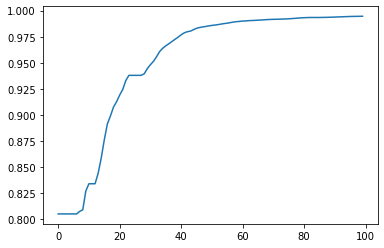

In [7]:
nnet = nn.NeuralNetworkClassifier(28*28, [10, 10], class_labels)
nnet.train(Xtrain.reshape(-1, 784), Ttrain, 100, 'scg')
Ytest, _ = nnet.use(Xtest.reshape(-1, 784))
print(nnet)
plt.plot(nnet.get_error_trace())
print(f'MNIST Test {100 * np.mean(Ytest == Ttest)}% correct, {nnet.all_weights.size} weights')

Now, try a convolutional neural network.  Our hidden layer structure here is specified as

    [[4, 8, 2]], [5]
    
This represents one convolutional layer with 4 units, each having a kernel size of `8 x 8` and stride of `2 x 2`, followed by one fully-connected layer with 5 units.  The output layer will have 10 units as before.

SCG: Epoch 10 ObjectiveF=0.90483
SCG: Epoch 20 ObjectiveF=0.94394
SCG: Epoch 30 ObjectiveF=0.96120
SCG: Epoch 40 ObjectiveF=0.97216
SCG: Epoch 50 ObjectiveF=0.97896
SCG: Epoch 60 ObjectiveF=0.98404
SCG: Epoch 70 ObjectiveF=0.98822
SCG: Epoch 80 ObjectiveF=0.99103
SCG: Epoch 90 ObjectiveF=0.99244
SCG: Epoch 100 ObjectiveF=0.99349
NeuralNetworkClassifier_CNN([28, 28, 1], [(4, 8, 2)], [5, 10], [0 1 2 3 4 5 6 7 8 9])
 Layer 0: n_units=4 kernel=8 stride=2 in_channels=1 in_rc=28 out_rc=11
 Layer 1: n_units=5
 Trained for 100 epochs.
 Final objective value is 0.9935.
MNIST CNN Test 88.38000000000001 % correct, with 2745 weights


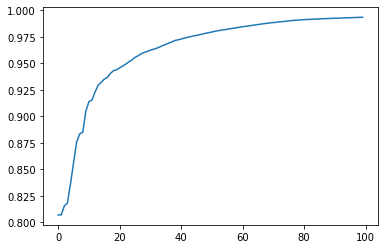

In [14]:
cnn = nn.NeuralNetworkClassifier_CNN([28, 28, 1], [(4, 8, 2)], [5], class_labels)
cnn.train(Xtrain, Ttrain, 100, 'scg')
Ytest, _ = cnn.use(Xtest)
print(cnn)
plt.plot(cnn.get_error_trace())
print(f'MNIST CNN Test {100 * np.mean(Ytest == Ttest)} % correct, with {cnn.all_weights.size} weights')

Let's take a look at the filters learned in the first layer.

In [15]:
W = cnn.Ws[0]
W.shape

(65, 4)

In [16]:
W = W[1:, :]
W.shape

(64, 4)

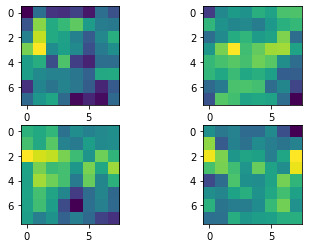

In [18]:
n_units = W.shape[-1]
ploti = 0
for i in range(n_units):
    ploti += 1
    plt.subplot(2, 2, ploti)
    plt.imshow(W[:, i].reshape(8, 8));